In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1000)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Pollutant levels or concentrations in the atmosphere lead to changes in the climate such as an increase in temperature and humidity levels. Measuring atmospheric pollutant concentrations requires air quality monitors and satellite imagery. Using other predictors such as temperature and humidity levels to determine concentration could be effective and less costly. This project aims to assess whether a linear regression model can be used to predict the average daily chemical concentration of tungsten oxide given averages of relative humidity, absolute humidity and temperature.

The data used was collected in an Italian city every hour in 2004, resulting in 9358 total observations in the dataset. The variables are: date, time, temperature (T), absolute humidity (AH), relative humidity (RH), and concentrations for carbon monoxide (CO), tin oxide (PT08.S1), non-methane hydrocarbons (NMHC), benzene (C6H6), titania (PT08.S1), nitric oxides (NOx, where x= 1,2,3, or 4), tungsten oxide (PT08.S3(NOx), and PT08.S4(NO2)), nitrogen dioxide(NO2), and indium oxide (PT08.S5).

In [2]:
air_quality <- read_csv("https://raw.githubusercontent.com/recompton/DSCI100_group_project/main/AirQualityUCI.csv?token=GHSAT0AAAAAACPKFCCOAGKVC5S4EIWAUNNAZPMZKGA")
head(air_quality)

New names:
• `` -> `...16`
• `` -> `...17`
Rows: 9471 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): Date
dbl  (13): CO_GT, PT08.S1_CO, NMHC_GT, C6H6_GT, PT08.S2_NMHC, Nox_GT, PT08.S...
lgl   (2): ...16, ...17
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17
<chr>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA
3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA
3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA
3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA
3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA
3/10/2004,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA


Before starting the analysis, we tidied our data with a single pollutant column, since we are only looking at tungsten oxide. In an ideal situation, we expect 365 observations in our wrangled data. During wrangling, we changed the pollutant column name from PT08.S4(NO2) to PT08.S4_NO2, as R was interpreting the name as a function. The format of the date was also changed from year/month/day to month-day-year, and split into 3 columns to compute the daily average. The data also had extraneous rows and columns which were removed. There were 130 rows with no values, and two columns labeled 16 and 17 which only had NA listed in every row.

In [3]:
air_quality_1 <- mutate(air_quality, Date = mdy(Date))
head(air_quality_1)

Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17
<date>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA
2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA
2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA
2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA
2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA
2004-03-10,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA


In [4]:
air_quality_2 <- air_quality_1 |>
mutate(year = year(Date),
month = month(Date),
day = day(Date))

head(air_quality_2)

Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17,year,month,day
<date>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<int>
2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA,2004,3,10
2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA,2004,3,10
2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA,2004,3,10
2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA,2004,3,10
2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA,2004,3,10
2004-03-10,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA,2004,3,10


In [5]:
sliced_air_quality <- air_quality_2 |>
slice(1:9357) 


head(sliced_air_quality)

Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17,year,month,day
<date>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<int>
2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA,2004,3,10
2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA,2004,3,10
2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA,2004,3,10
2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA,2004,3,10
2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA,2004,3,10
2004-03-10,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA,2004,3,10


In [6]:
avg_air_quality <- sliced_air_quality |>
filter(PT08.S4_NO2	 != -200)|>
filter(T != -200) |>
filter(RH != -200) |>
filter(AH != -200) |>
group_by(month, day) |>
summarize(
    daily_avg_TO = mean(PT08.S4_NO2, na.rm = TRUE),
    daily_avg_T = mean(T, na.rm = TRUE),
    daily_avg_RH = mean(RH, na.rm = TRUE),
    daily_avg_AH = mean(AH, na.rm = TRUE))


avg_air_quality_split <- initial_split(avg_air_quality, prop = 0.75, strata = daily_avg_TO)
avg_air_quality_train <- training(avg_air_quality_split)
avg_air_quality_test <- testing(avg_air_quality_split)

avg_air_quality_train
avg_air_quality_test

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


month,day,daily_avg_TO,daily_avg_T,daily_avg_RH,daily_avg_AH
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,1226.5417,13.445833,61.07083,0.9321417
1,16,948.3333,7.525000,47.77917,0.4804167
1,17,1163.3333,6.666667,46.91667,0.4469125
1,19,1072.4583,7.816667,64.99583,0.6895000
1,20,1136.7500,10.075000,44.24583,0.5263417
1,22,1283.5000,9.941667,55.85417,0.6523542
1,23,998.7500,5.816667,53.88333,0.5014125
1,24,977.4583,7.675000,47.88333,0.4938125
1,27,870.9583,5.270833,39.61250,0.3543292


month,day,daily_avg_TO,daily_avg_T,daily_avg_RH,daily_avg_AH
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1032.6250,6.870833,50.79583,0.4989708
1,2,1063.1429,6.580952,59.28095,0.5709476
1,9,1257.7500,14.437500,58.99583,0.9614458
1,15,1210.5000,6.429167,70.20417,0.6710333
1,25,869.3750,4.512500,50.97083,0.4323125
1,26,873.0417,4.208333,49.48333,0.4119333
1,31,1001.5000,7.283333,31.80833,0.3119542
2,1,1184.4167,6.625000,51.74167,0.5041875
2,4,1081.7500,7.466667,50.17917,0.4960292


In [7]:
num_rows <- nrow(avg_air_quality_train)
num_rows

[1] 265

We chose PT08.S4(NO2) because it has 357 rows total (265 in the training data) after filtering out the NA (-200) values. Additionally, this chemical showed promise for a good correlation when visualizing its relationship with RH, AH and T in our preliminary exploratory analysis. To make our analysis reproducible, we set the seed to 1000.

To visualize the outcome of the regression model, we will have 3 scatterplots with AH, RH and temperature on the x-axis and concentration of tungsten oxide on the y-axis. We will also include a regression line in each plot.

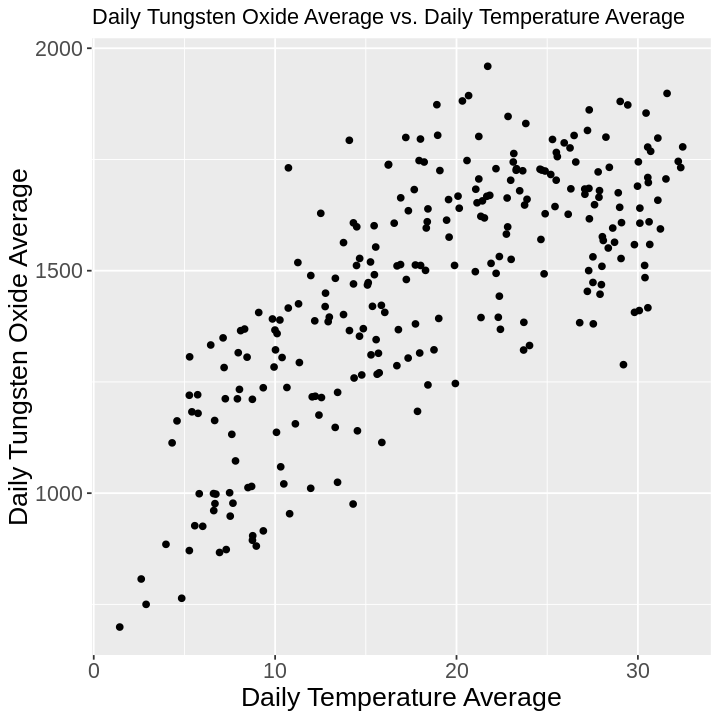

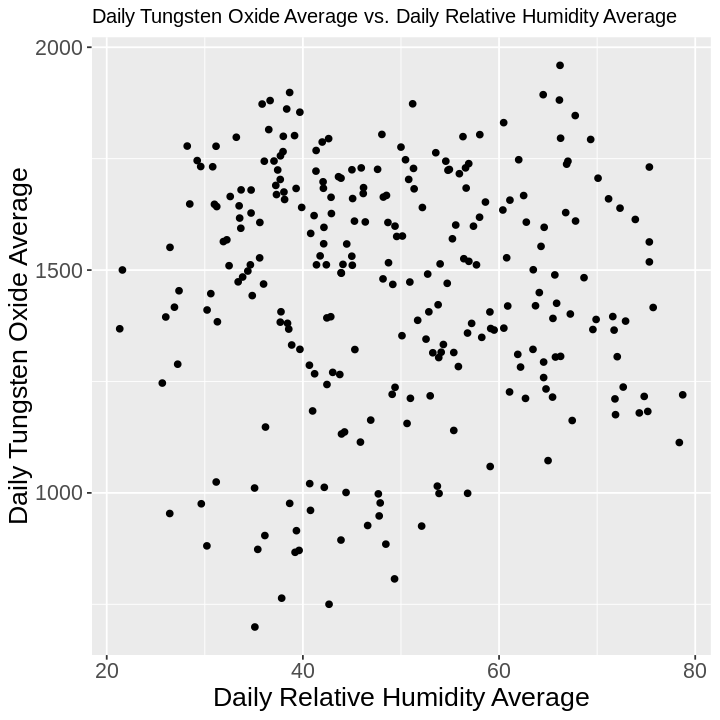

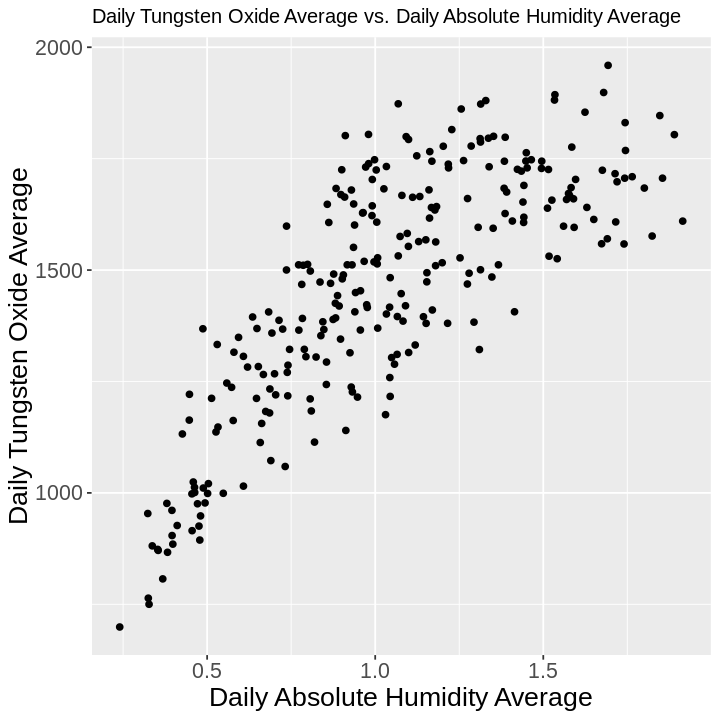

In [8]:
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(avg_air_quality_train, aes(x = daily_avg_T, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Temperature Average",
       x = "Daily Temperature Average",
       y = "Daily Tungsten Oxide Average") +
theme(text = element_text(size = 16)) +
theme(plot.title = element_text(size = 13))

ggplot(avg_air_quality_train, aes(x = daily_avg_RH, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Relative Humidity Average",
       x = "Daily Relative Humidity Average",
       y = "Daily Tungsten Oxide Average") +
theme(text = element_text(size = 16)) +
theme(plot.title = element_text(size = 12))

ggplot(avg_air_quality_train, aes(x = daily_avg_AH, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Absolute Humidity Average",
       x = "Daily Absolute Humidity Average",
       y = "Daily Tungsten Oxide Average") + 
theme(text = element_text(size = 16)) +
theme(plot.title = element_text(size = 12))

Following our data analysis and visualization, we expect to find that as temperature and humidity levels increase, more levels of tungsten oxide will be present in the atmosphere. We also expect chemical accumulation in the atmosphere over time, resulting in a regression line with a positive slope.These findings can be useful in determining how pollutant levels change overtime and if temperature and humidity levels can be good predictors. If they are not good predictors, then there will not be a clear relationship. These findings could also lead to questions such as: If we expanded the study by year from 2004 to 2022, would a relationship be more prominent? What are the large scale effects of pollutant accumulation? Are there any other factors besides pollutant accumulation which lead to increase AH, RH or temperature?

In [9]:
lm_spec <- linear_reg() |> set_engine("lm") |>
          set_mode("regression")
lm_spec


lm_recipe_T <- recipe(daily_avg_TO ~ daily_avg_T, data = avg_air_quality_train)

lm_fit_T <- workflow() |>
       add_recipe(lm_recipe_T) |>
       add_model(lm_spec) |>
       fit(data = avg_air_quality_train)


lm_fit_T


Linear Regression Model Specification (regression)

Computational engine: lm 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)  daily_avg_T  
     997.73        24.95  


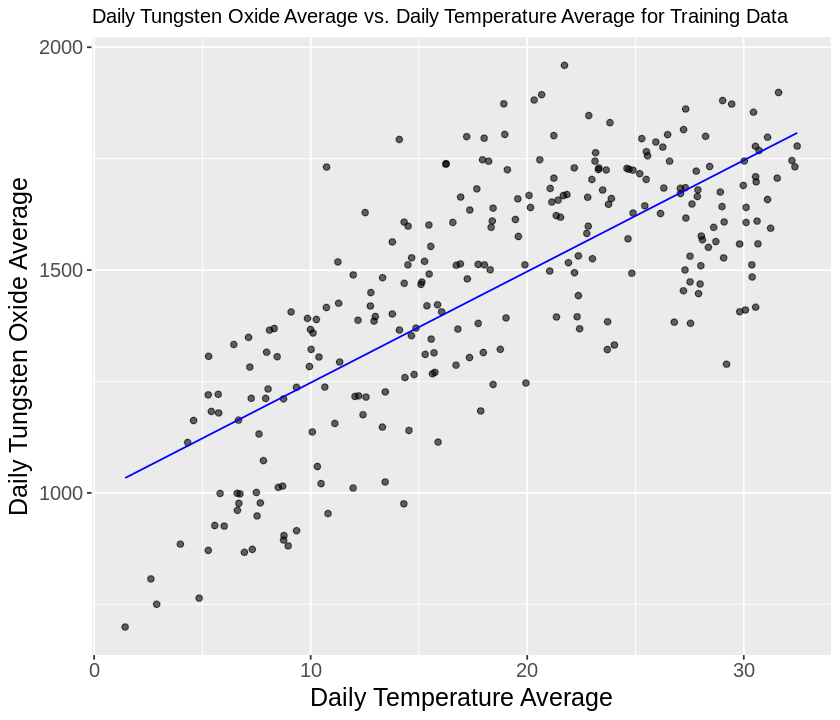

In [10]:
preds_T <- lm_fit_T |>
   predict(avg_air_quality_train) |>
   bind_cols(avg_air_quality_train)

options(repr.plot.width = 7, repr.plot.height = 6)

lm_predictions_T <- preds_T |>
     ggplot(aes(x = daily_avg_T, y = daily_avg_TO)) +
         geom_point(alpha = 0.6) +
         geom_line(
             mapping = aes(x = daily_avg_T, y = .pred), 
             color = "blue") +
         labs(title = "Daily Tungsten Oxide Average vs. Daily Temperature Average for Training Data",
       x = "Daily Temperature Average",
       y = "Daily Tungsten Oxide Average") +
         theme(text = element_text(size = 15)) +
        theme(plot.title = element_text(size = 12))


lm_predictions_T

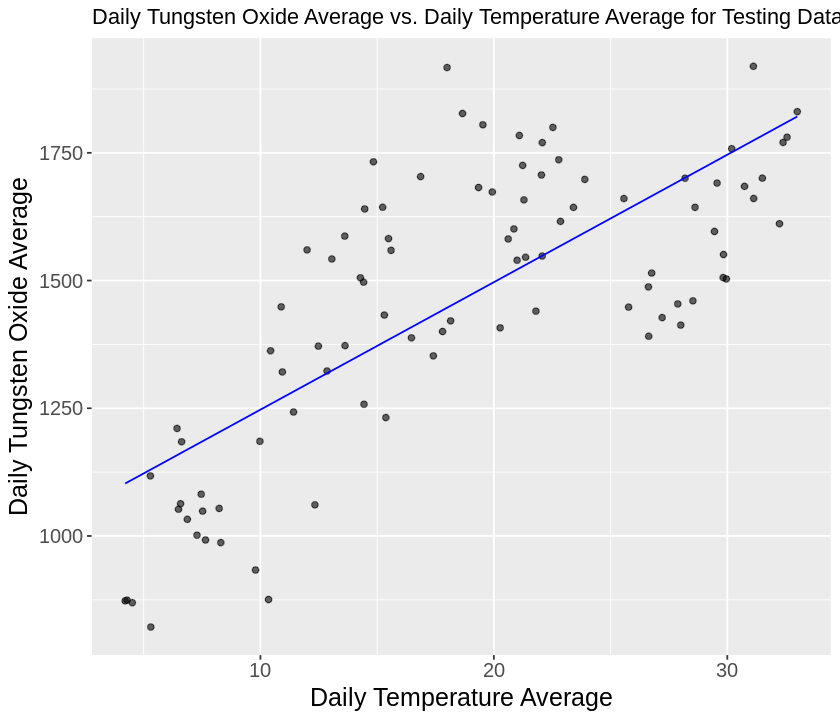

In [11]:
test_preds_T <- lm_fit_T |>
         predict(avg_air_quality_test) |>
         bind_cols(avg_air_quality_test) 

options(repr.plot.width = 7, repr.plot.height = 6)

lm_predictions_test_T <- test_preds_T |>
      ggplot(aes(x = daily_avg_T, y = daily_avg_TO)) +
         geom_point(alpha = 0.6) +
         geom_line(
             mapping = aes(x = daily_avg_T, y = .pred), 
             color = "blue") +
         labs(title = "Daily Tungsten Oxide Average vs. Daily Temperature Average for Testing Data",
       x = "Daily Temperature Average",
       y = "Daily Tungsten Oxide Average") +
         theme(text = element_text(size = 15)) +
        theme(plot.title = element_text(size = 13))
lm_predictions_test_T

The equation for the straight line is:

Daily Tungsten Oxide Average = β0 + β1⋅(Daily Temperature Average), where β0 is the vertical intercept of the line (the daily average of Tungsten Oxide when the daily average temp is 0) and β1 is the slope of the line (how daily average of Tungsten Oxide changes when daily temperature increases by one unit)

In [12]:
air_quality_test_results_T <- lm_fit_T |>
  predict(avg_air_quality_test) |>
  bind_cols(avg_air_quality_test) |>
  mutate(residuals_T = .pred - daily_avg_TO) |>
    select(-daily_avg_RH, -daily_avg_AH)

air_quality_regression_metrics_T <- air_quality_test_results_T |>
   metrics(truth = daily_avg_TO, estimate = .pred)

air_quality_RMSPE_T <- air_quality_regression_metrics_T |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

head(air_quality_test_results_T)

air_quality_regression_metrics_T

air_quality_RMSPE_T

.pred,month,day,daily_avg_TO,daily_avg_T,residuals_T
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1169.172,1,1,1032.6250,6.870833,136.54740
1161.939,1,2,1063.1429,6.580952,98.79642
1357.976,1,9,1257.7500,14.437500,100.22605
1158.152,1,15,1210.5000,6.429167,-52.34808
1110.327,1,25,869.3750,4.512500,240.95220
1102.738,1,26,873.0417,4.208333,229.69596


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,182.832411
rsq,standard,0.561288
mae,standard,151.186205


[1] 182.8324

The RMSPE for the model between temperature and tungsten oxide is roughly 182.83.

In [13]:
lm_recipe_AH <- recipe(daily_avg_TO ~ daily_avg_AH, data = avg_air_quality_train)

lm_fit_AH <- workflow() |>
       add_recipe(lm_recipe_AH) |>
       add_model(lm_spec) |>
       fit(data = avg_air_quality_train)


lm_fit_AH

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  daily_avg_AH  
       887.8         553.6  


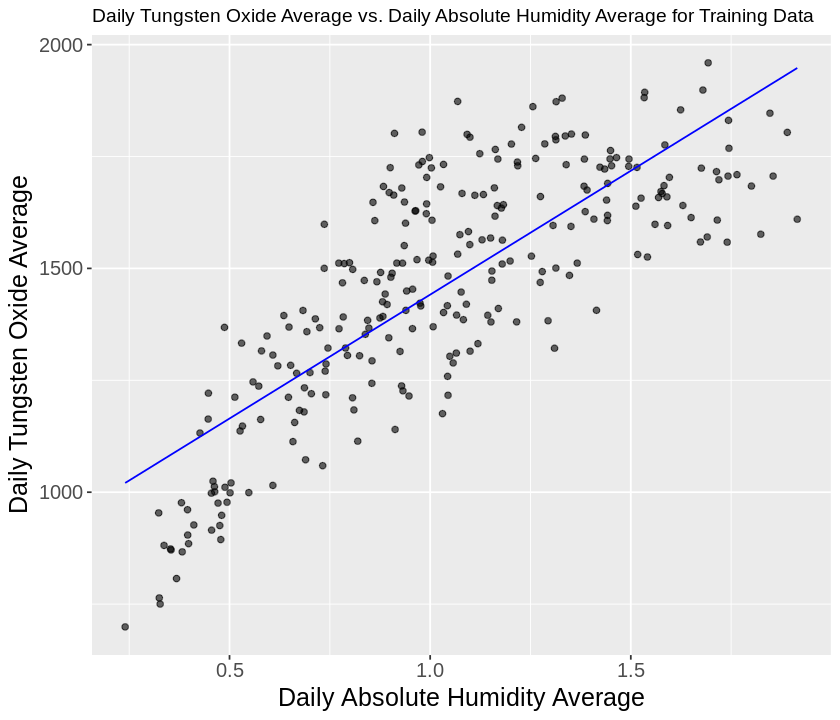

In [14]:
preds_AH <- lm_fit_AH |>
   predict(avg_air_quality_train) |>
   bind_cols(avg_air_quality_train)

options(repr.plot.width = 7, repr.plot.height = 6)


lm_predictions_AH <- preds_AH |>
     ggplot(aes(x = daily_avg_AH, y = daily_avg_TO)) +
         geom_point(alpha = 0.6) +
         geom_line(
             mapping = aes(x = daily_avg_AH, y = .pred), 
             color = "blue") +
         labs(title = "Daily Tungsten Oxide Average vs. Daily Absolute Humidity Average for Training Data",
       x = "Daily Absolute Humidity Average",
       y = "Daily Tungsten Oxide Average") +
         theme(text = element_text(size = 15)) +
        theme(plot.title = element_text(size = 11.5))


lm_predictions_AH

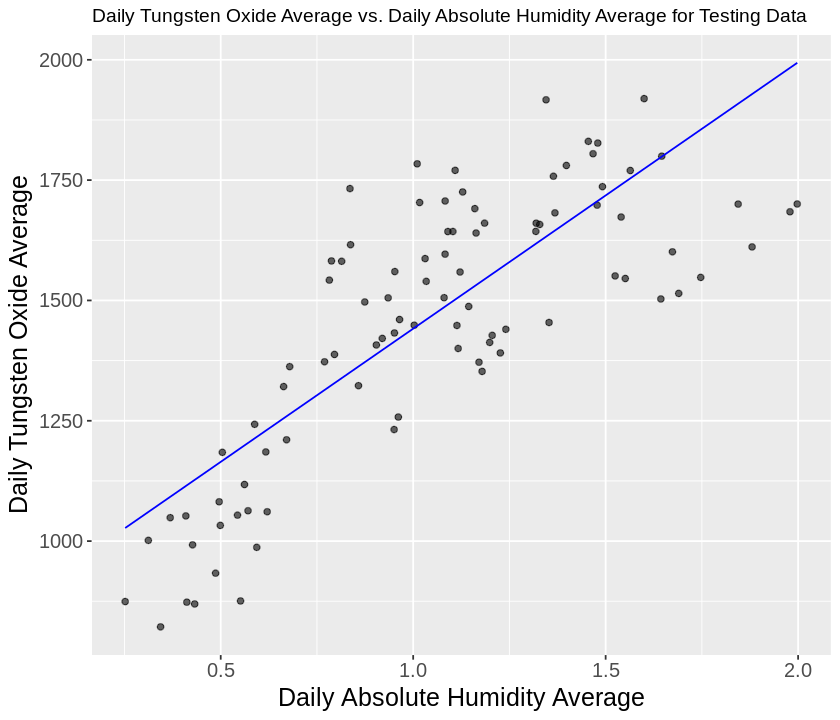

In [15]:
test_preds_AH <- lm_fit_AH |>
         predict(avg_air_quality_test) |>
         bind_cols(avg_air_quality_test) 

options(repr.plot.width = 7, repr.plot.height = 6)

lm_predictions_test_AH <- test_preds_AH |>
      ggplot(aes(x = daily_avg_AH, y = daily_avg_TO)) +
         geom_point(alpha = 0.6) +
         geom_line(
             mapping = aes(x = daily_avg_AH, y = .pred), 
             color = "blue") +
         labs(title = "Daily Tungsten Oxide Average vs. Daily Absolute Humidity Average for Testing Data",
       x = "Daily Absolute Humidity Average",
       y = "Daily Tungsten Oxide Average") +
         theme(text = element_text(size = 15)) +
        theme(plot.title = element_text(size = 11.5))  

lm_predictions_test_AH

The equation for the straight line is:

Daily Tungsten Oxide Average = β0 + β1⋅(daily absolute humidity average), where β0 is the vertical intercept of the line (the daily average of Tungsten Oxide when the daily absolute humidity average is 0) and β1 is the slope of the line (how daily average of Tungsten Oxide changes when daily absolute humidity average increases by one unit)

In [16]:
air_quality_test_results_AH <- lm_fit_AH |>
  predict(avg_air_quality_test) |>
  bind_cols(avg_air_quality_test) |>
  mutate(residuals_AH = .pred - daily_avg_TO) |>
    select(-daily_avg_T, -daily_avg_RH)

air_quality_regression_metrics_AH <- air_quality_test_results_AH |>
   metrics(truth = daily_avg_TO, estimate = .pred)

air_quality_RMSPE_AH <- air_quality_regression_metrics_AH |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

head(air_quality_test_results_AH)

air_quality_regression_metrics_AH

air_quality_RMSPE_AH

.pred,month,day,daily_avg_TO,daily_avg_AH,residuals_AH
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1164.034,1,1,1032.6250,0.4989708,131.40911
1203.879,1,2,1063.1429,0.5709476,140.73591
1420.049,1,9,1257.7500,0.9614458,162.29936
1259.284,1,15,1210.5000,0.6710333,48.78385
1127.134,1,25,869.3750,0.4323125,257.75863
1115.852,1,26,873.0417,0.4119333,242.81054


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,169.3868356
rsq,standard,0.6280992
mae,standard,140.6350711


[1] 169.3868

The RMSPE for the model between absolute humidity and tungsten oxide is roughly 169.39.

In [17]:
lm_recipe_RH <- recipe(daily_avg_TO ~ daily_avg_RH, data = avg_air_quality_train)

lm_fit_RH <- workflow() |>
       add_recipe(lm_recipe_RH) |>
       add_model(lm_spec) |>
       fit(data = avg_air_quality_train)


lm_fit_RH

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  daily_avg_RH  
   1470.2414       -0.2397  


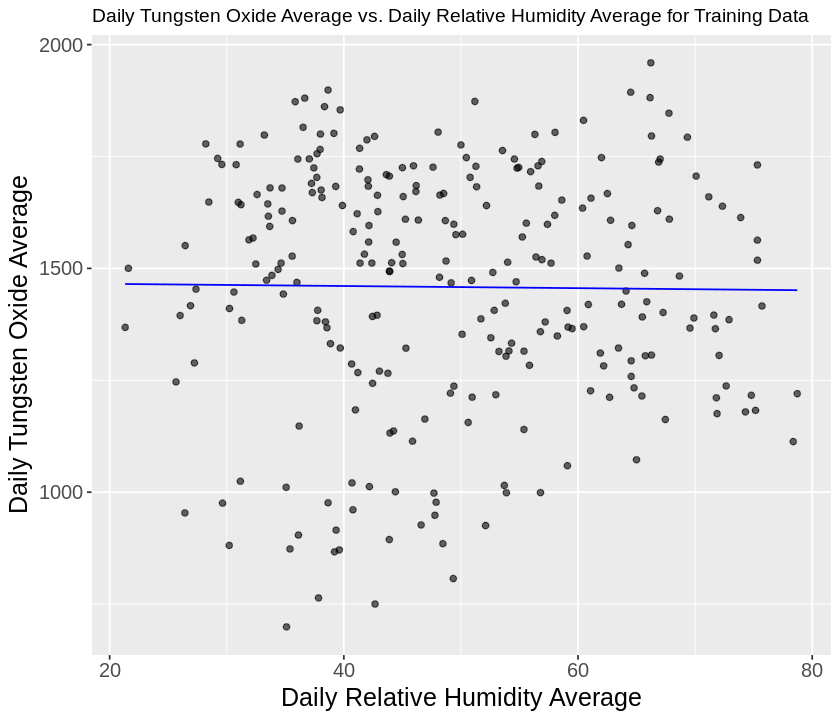

In [18]:
preds_RH <- lm_fit_RH |>
   predict(avg_air_quality_train) |>
   bind_cols(avg_air_quality_train)

options(repr.plot.width = 7, repr.plot.height = 6)

lm_predictions_RH <- preds_RH |>
     ggplot(aes(x = daily_avg_RH, y = daily_avg_TO)) +
         geom_point(alpha = 0.6) +
         geom_line(
             mapping = aes(x = daily_avg_RH, y = .pred), 
             color = "blue") +
         labs(title = "Daily Tungsten Oxide Average vs. Daily Relative Humidity Average for Training Data",
       x = "Daily Relative Humidity Average",
       y = "Daily Tungsten Oxide Average") +
         theme(text = element_text(size = 15)) +
        theme(plot.title = element_text(size = 11.5))


lm_predictions_RH

The equation for the straight line is:

Daily Tungsten Oxide Average = β0 + β1⋅(daily relative humidity average),
where β0 is the vertical intercept of the line (the daily average of Tungsten Oxide when the daily relative humidity average is 0) and β1 is the slope of the line (how daily average of Tungsten Oxide changes when daily relative humidity average increases by one unit). From the graph, we can see that relative humidity is not a good predictor, so we will not regre

In [20]:
air_quality_test_results_RH <- lm_fit_RH |>
  predict(avg_air_quality_test) |>
  bind_cols(avg_air_quality_test) |>
  mutate(residuals_RH = .pred - daily_avg_TO) |>
    select(-daily_avg_AH, -daily_avg_T)

air_quality_regression_metrics_RH <- air_quality_test_results_RH |>
   metrics(truth = daily_avg_TO, estimate = .pred)

air_quality_RMSPE_RH <- air_quality_regression_metrics_RH |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

head(air_quality_test_results_RH)

air_quality_regression_metrics_RH

air_quality_RMSPE_RH

.pred,month,day,daily_avg_TO,daily_avg_RH,residuals_RH
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1458.066,1,1,1032.6250,50.79583,425.4413
1456.033,1,2,1063.1429,59.28095,392.8897
1456.101,1,9,1257.7500,58.99583,198.3509
1453.414,1,15,1210.5000,70.20417,242.9144
1458.024,1,25,869.3750,50.97083,588.6494
1458.381,1,26,873.0417,49.48333,585.3393


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.760657e+02
rsq,standard,2.588402e-03
mae,standard,2.242051e+02


[1] 276.0657

The RMSPE for the model between relative humidity and tungsten oxide is roughly 276.07.

In [21]:
lm_recipe_both <- recipe(daily_avg_TO ~ daily_avg_T + daily_avg_AH, data = avg_air_quality_train)

lm_fit_both <- workflow() |>
       add_recipe(lm_recipe_both) |>
       add_model(lm_spec) |>
       fit(data = avg_air_quality_train)

preds_RH <- lm_fit_both |>
    predict(avg_air_quality_test) |>
    bind_cols(avg_air_quality_test) |>
    metrics(truth = daily_avg_TO, estimate = .pred)

preds_RH

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,160.7764351
rsq,standard,0.6639992
mae,standard,132.9776453


In [22]:
lm_fit_both

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)   daily_avg_T  daily_avg_AH  
      870.99         10.34        384.65  


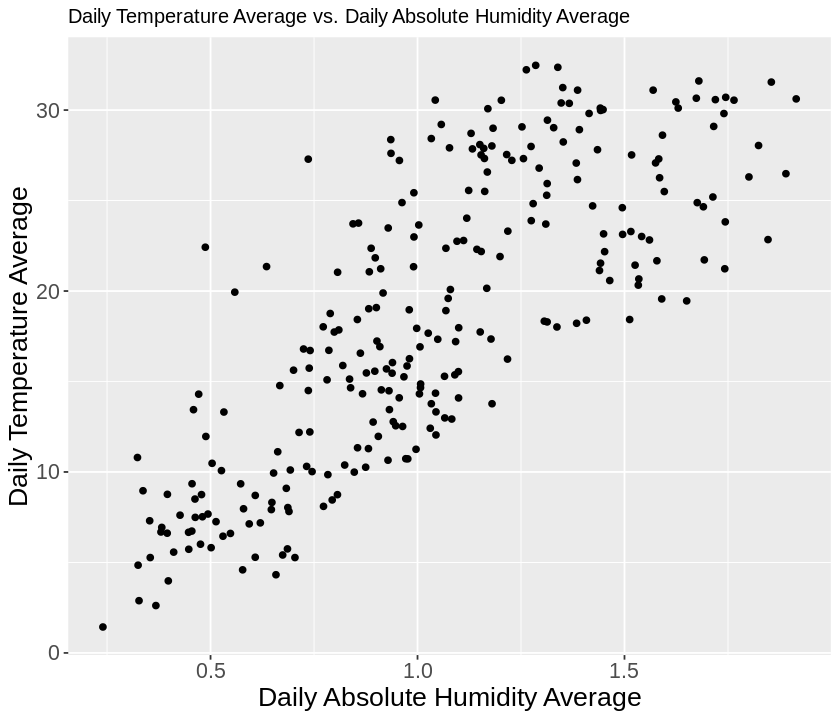

In [23]:
ggplot(avg_air_quality_train, aes(x = daily_avg_AH, y = daily_avg_T)) +
  geom_point() +
  labs(title = "Daily Temperature Average vs. Daily Absolute Humidity Average",
       x = "Daily Absolute Humidity Average",
       y = "Daily Temperature Average") + 
theme(text = element_text(size = 16)) +
theme(plot.title = element_text(size = 12))

It seems we have multicollinearity in our regression. The two predictor variables, temperature and absolute humidity, are positively correlated.